In [236]:
%run constants.ipynb
%run dataloaders.ipynb
%run utils.ipynb
%run prior.ipynb
%run models.ipynb
%run coresets.ipynb
%run train_and_test.ipynb
%run config.ipynb

In [235]:
def print_if(msg, print_progress):
    if print_progress:
        print(msg)

def run_experiment_for(model, print_progress=False):
    config = model.config
    dataloaders = config.dataloaders
    coreset_alg = config.coreset_alg
    assert coreset_alg is None or coreset_alg.coresets == []  # should initially be empty
    results = np.zeros((len(config.tasks), len(config.tasks)))
    results_std = np.zeros((len(config.tasks), len(config.tasks)))
    is_vcl = isinstance(model, VCLNN)
    
    # Train and evaluate
    for task_id in range(len(config.tasks)):
        print_if(f"\nTraining on Task {task_id+1} ...", print_progress)
        train_loader, _ = dataloaders[task_id]
        # Train on non-coreset data
        train(model, train_loader, task_id)
        print_if(f"... Finished training on Task {task_id+1}", print_progress)
        
        # Train on new coreset
        if is_vcl and coreset_alg is not None and config.coreset_size > 0:  # VCL models with coresets
            coreset_alg.add_coreset(train_loader)
            # Train on coresets from previous tasks
            for prev_task in range(task_id+1):
                print_if(f"\nRe-training on Task {prev_task+1} ...", print_progress)
                train(model, coreset_alg.coresets[prev_task], prev_task)
        print_if('', print_progress)
        
        # Evaluate on previous tasks
        for curr_t in range(task_id+1):
            _, test_loader = dataloaders[curr_t]
            score, std = test(model, test_loader, curr_t, ret_std=True)
            print_if(f"Task {(curr_t+1):2d}  {config.eval_metric}: \
                        {np.round(score, 4):0.4f} ± {np.round(std, 4):0.4f}", print_progress)
            results[task_id, curr_t] = score
            results_std[task_id, curr_t] = std
        print_if('', print_progress)

        if is_vcl and config.update_prior:  # update prior for VCL models
            model.update_priors()
            
    return results, results_std

In [227]:
from copy import deepcopy

In [228]:
def run_experiment(config, ret_std=False, print_progress=False):
    """Run complete VCL experiment"""
    exp_random_config = deepcopy(config)
    exp_random_config.prior_type = 'exponential'
    
    # Initialize models
    vanillaNN = VanillaNN(config).to(DEVICE)
    gaussian_vclNN = VCLNN(config).to(DEVICE)
    exp_vclNN = VCLNN(exp_random_config).to(DEVICE)

    vanilla_results, vanilla_results_std = run_experiment_for(vanillaNN, print_progress)
    gaussian_random_vcl_results, gaussian_random_vcl_results_std = run_experiment_for(gaussian_vclNN, print_progress)
    exp_random_vcl_results, exp_random_vcl_results_std = run_experiment_for(exp_vclNN, print_progress)
    
    results = { 'Vanilla': vanilla_results, 'GaussianVCL': gaussian_random_vcl_results, 'ExpVCL': exp_random_vcl_results }
    results_std = { 'Vanilla': vanilla_results_std, 'GaussianVCL': gaussian_random_vcl_results_std, 'ExpVCL': exp_random_vcl_results_std }
    
    return results if not ret_std else (results, results_std)

# Minimum required extensions

In [73]:
def run_experiment(config, ret_std=False, print_progress=False):
    """Run complete VCL experiment"""
    exp_random_config = deepcopy(config)
    exp_random_config.prior_type = 'exponential'
    
    # Initialize models
    vanillaNN = VanillaNN(config).to(DEVICE)
    gaussian_vclNN = VCLNN(config).to(DEVICE)
    exp_vclNN = VCLNN(exp_random_config).to(DEVICE)

    vanilla_results, vanilla_results_std = run_experiment_for(vanillaNN, print_progress)
    gaussian_random_vcl_results, gaussian_random_vcl_results_std = run_experiment_for(gaussian_vclNN, print_progress)
    exp_random_vcl_results, exp_random_vcl_results_std = run_experiment_for(exp_vclNN, print_progress)
    
    results = { 'Vanilla': vanilla_results, 'GaussianVCL': gaussian_random_vcl_results, 'ExpVCL': exp_random_vcl_results }
    results_std = { 'Vanilla': vanilla_results_std, 'GaussianVCL': gaussian_random_vcl_results_std, 'ExpVCL': exp_random_vcl_results_std }
    
    return results if not ret_std else (results, results_std)

In [75]:
config = ExperimentConfig()
config.dataset_type = 'split'
config.task_type = 'classification'
config.coreset_alg_name = 'random'

# Set random seeds
torch.manual_seed(777)
np.random.seed(777)

# Run experiment
split_cla_results, split_cla_results_std = run_experiment(config, ret_std=True, print_progress=True)


Training on Task 1 ...
... Finished training on Task 1

Task  1  Accuracy:                         0.9991 ± 0.0016


Training on Task 2 ...
... Finished training on Task 2

Task  1  Accuracy:                         0.9987 ± 0.0026
Task  2  Accuracy:                         0.9932 ± 0.0064


Training on Task 3 ...
... Finished training on Task 3

Task  1  Accuracy:                         0.7185 ± 0.0170
Task  2  Accuracy:                         0.9697 ± 0.0121
Task  3  Accuracy:                         0.9990 ± 0.0017


Training on Task 4 ...
... Finished training on Task 4

Task  1  Accuracy:                         0.5926 ± 0.0292
Task  2  Accuracy:                         0.9133 ± 0.0170
Task  3  Accuracy:                         0.9794 ± 0.0093
Task  4  Accuracy:                         0.9990 ± 0.0026


Training on Task 5 ...
... Finished training on Task 5

Task  1  Accuracy:                         0.6080 ± 0.0519
Task  2  Accuracy:                         0.9481 ± 0.0135
Tas

In [76]:
split_cla_results

{'Vanilla': array([[0.99913194, 0.        , 0.        , 0.        , 0.        ],
        [0.99869792, 0.99316406, 0.        , 0.        , 0.        ],
        [0.71849088, 0.96966797, 0.99902344, 0.        , 0.        ],
        [0.59257748, 0.91329297, 0.97943264, 0.99902344, 0.        ],
        [0.60796927, 0.94808985, 0.98583984, 0.99560547, 0.98892547]]),
 'Gaussian VCL': array([[0.99956597, 0.        , 0.        , 0.        , 0.        ],
        [0.99956597, 0.95542578, 0.        , 0.        , 0.        ],
        [0.99956597, 0.95253125, 0.93860757, 0.        , 0.        ],
        [0.99956597, 0.948125  , 0.94415729, 0.98359476, 0.        ],
        [0.99956597, 0.91091016, 0.95349419, 0.98830139, 0.9431523 ]]),
 'Exponential VCL': array([[0.99869792, 0.        , 0.        , 0.        , 0.        ],
        [0.99869792, 0.98921094, 0.        , 0.        , 0.        ],
        [0.99530343, 0.94374219, 0.99609375, 0.        , 0.        ],
        [0.99696181, 0.94073047, 0.96624

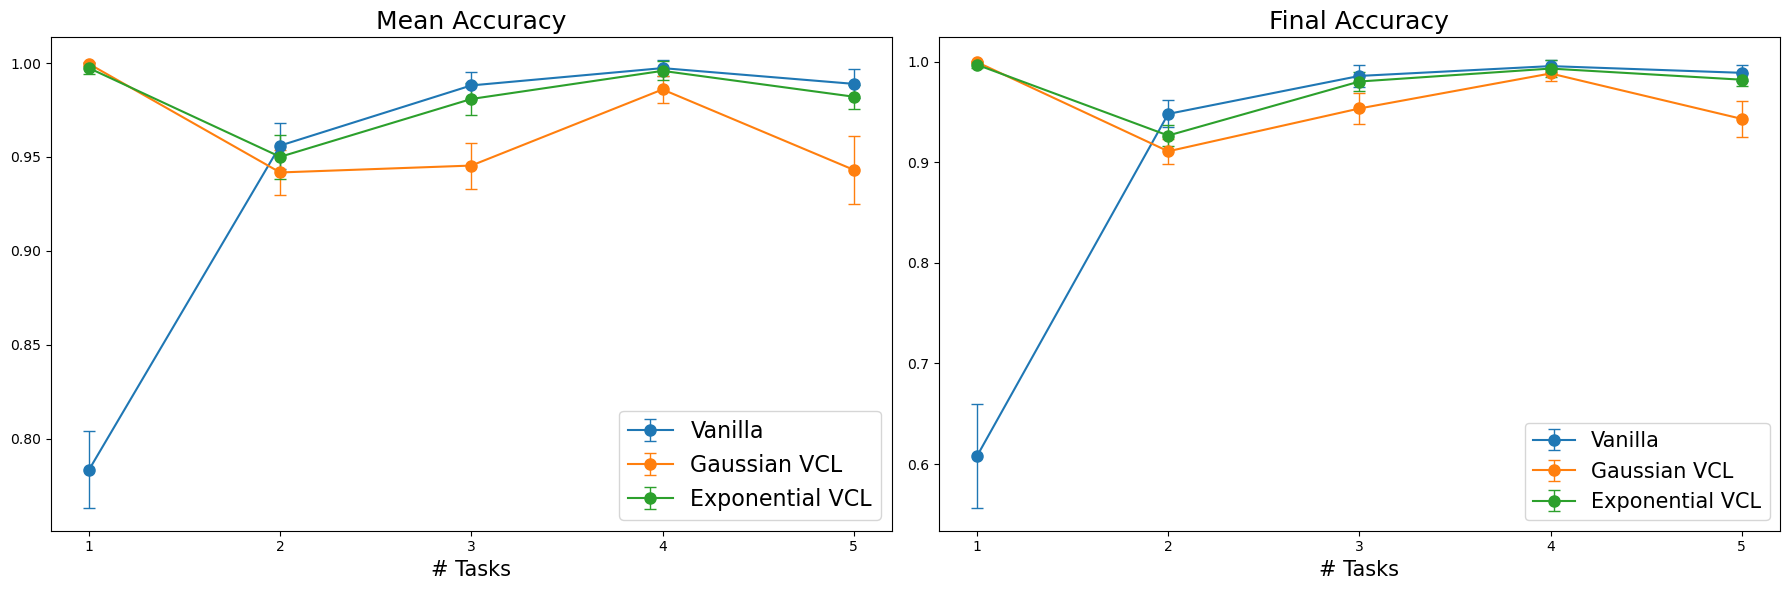

In [77]:
plot_results(config, split_cla_results, results_std=split_cla_results_std)

In [78]:
config = ExperimentConfig()
config.dataset_type = 'split'
config.task_type = 'regression'
config.coreset_alg_name = 'random'
# config.init_prior_scale = 0.01

# Run experiment
split_reg_results, split_reg_results_std = run_experiment(config, ret_std=True)

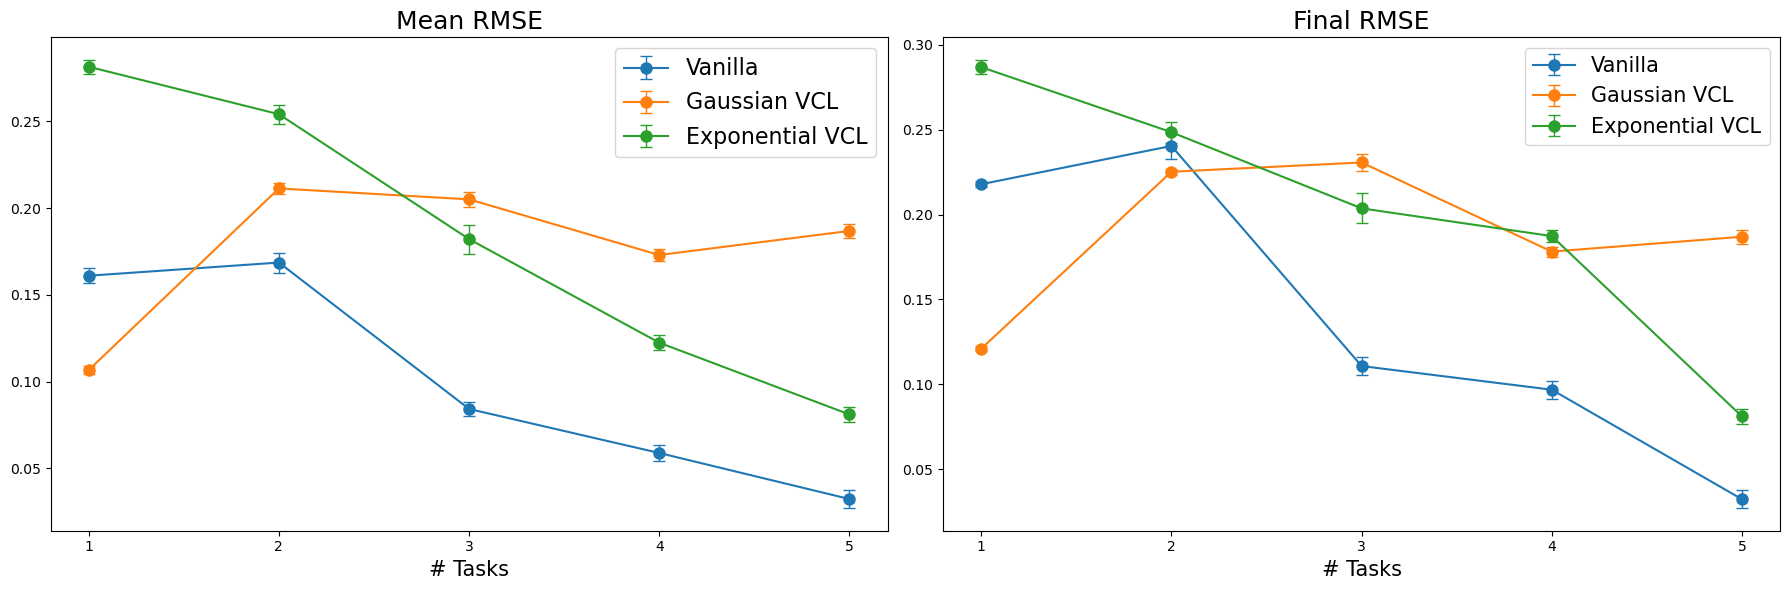

In [79]:
plot_results(config, split_reg_results, split_reg_results_std)

# Computing loss in different ways
1. Only treat q0 as exponential, then switch back to KL between two Gaussians
2. Treat all q_{t-1}'s as exponential (i.e., always take KL between a Gaussian and an Exponential)

In [167]:
def cmp_exp_prior_loss(config, ret_std=False, print_progress=False):
    """Run complete VCL experiment"""
    exp_config = deepcopy(config)
    exp_config.prior_type = 'exponential'
    exp_gaussian_config = deepcopy(exp_config)
    exp_gaussian_config.update_prior_type = True
    
    # Initialize models
    vanillaNN = VanillaNN(config).to(DEVICE)
    gaussian_vclNN = VCLNN(config).to(DEVICE)
    exp_vclNN = VCLNN(exp_config).to(DEVICE)
    exp_gaussian_vclNN = VCLNN(exp_gaussian_config).to(DEVICE)  # updates prior

    vanilla_results, vanilla_results_std = run_experiment_for(vanillaNN, print_progress)
    gaussian_vcl_results, gaussian_vcl_results_std = run_experiment_for(gaussian_vclNN, print_progress)
    exp_vcl_results, exp_vcl_results_std = run_experiment_for(exp_vclNN, print_progress)
    exp_gaussian_vcl_results, exp_gaussian_vcl_results_std = run_experiment_for(exp_gaussian_vclNN, print_progress)
    
    results = { 'Vanilla': vanilla_results, 'GaussianVCL': gaussian_vcl_results, 
                'ExpVCL': exp_vcl_results, 'ExpGaus VCL': exp_gaussian_vcl_results }
    results_std = { 'Vanilla': vanilla_results_std, 'GaussianVCL': gaussian_vcl_results_std, 
                    'ExpVCL': exp_vcl_results_std, 'ExpGaus VCL': exp_gaussian_vcl_results_std }
    
    return results if not ret_std else (results, results_std)

In [168]:
config = ExperimentConfig()
config.task_type = 'classification'
config.coreset_alg_name = 'random'

# Set random seeds
torch.manual_seed(777)
np.random.seed(888)

cmp_exploss_results, cmp_exploss_results_std = cmp_exp_prior_loss(config, ret_std=True)

update_prior_type = True
update_prior_type = True
update_prior_type = True
update_prior_type = True
update_prior_type = True
update_prior_type = True
update_prior_type = True
update_prior_type = True
update_prior_type = True
update_prior_type = True
update_prior_type = True
update_prior_type = True
update_prior_type = True
update_prior_type = True
update_prior_type = True
update_prior_type = True
update_prior_type = True
update_prior_type = True
update_prior_type = True
update_prior_type = True
update_prior_type = True
update_prior_type = True
update_prior_type = True
update_prior_type = True
update_prior_type = True
update_prior_type = True
update_prior_type = True
update_prior_type = True
update_prior_type = True
update_prior_type = True
update_prior_type = True
update_prior_type = True
update_prior_type = True
update_prior_type = True
update_prior_type = True


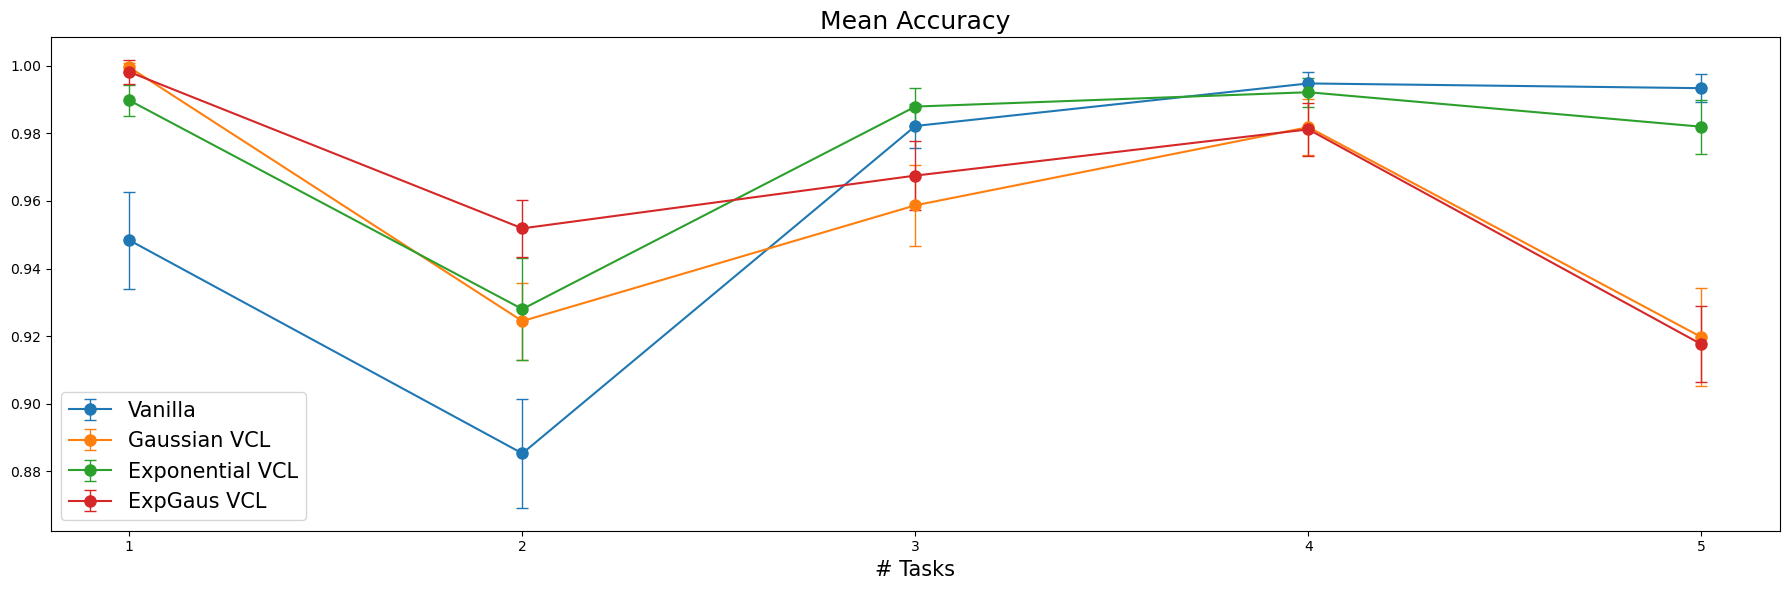

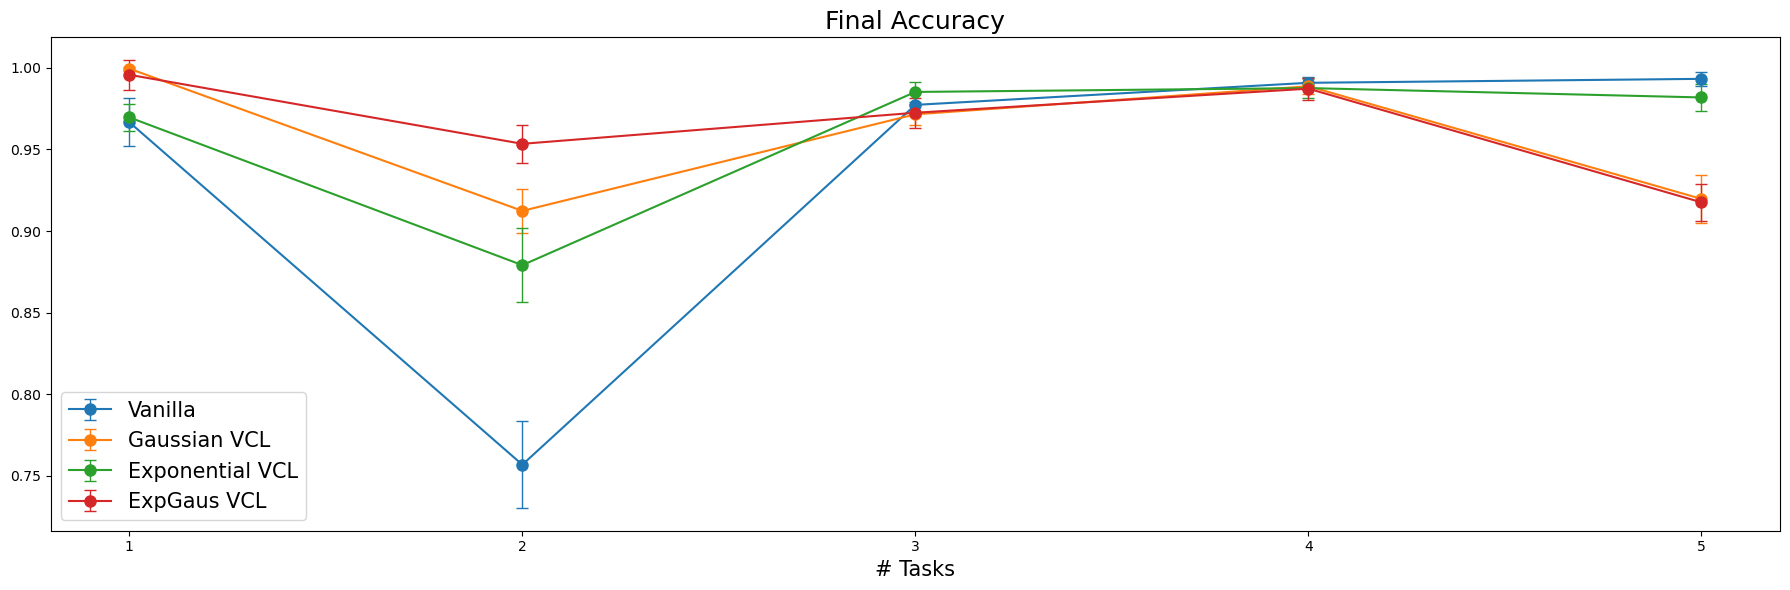

In [169]:
plot_mean_results(config, cmp_exploss_results, cmp_exploss_results_std)
plot_final_results(config, cmp_exploss_results, cmp_exploss_results_std)

In [170]:
config = ExperimentConfig()
config.task_type = 'regression'
config.coreset_alg_name = 'random'

# Set random seeds
torch.manual_seed(777)
np.random.seed(888)

cmp_exploss_reg_results, cmp_exploss_reg_results_std = cmp_exp_prior_loss(config, ret_std=True)

update_prior_type = True
update_prior_type = True
update_prior_type = True
update_prior_type = True
update_prior_type = True
update_prior_type = True
update_prior_type = True
update_prior_type = True
update_prior_type = True
update_prior_type = True
update_prior_type = True
update_prior_type = True
update_prior_type = True
update_prior_type = True
update_prior_type = True
update_prior_type = True
update_prior_type = True
update_prior_type = True
update_prior_type = True
update_prior_type = True
update_prior_type = True
update_prior_type = True
update_prior_type = True
update_prior_type = True
update_prior_type = True
update_prior_type = True
update_prior_type = True
update_prior_type = True
update_prior_type = True
update_prior_type = True
update_prior_type = True
update_prior_type = True
update_prior_type = True
update_prior_type = True
update_prior_type = True


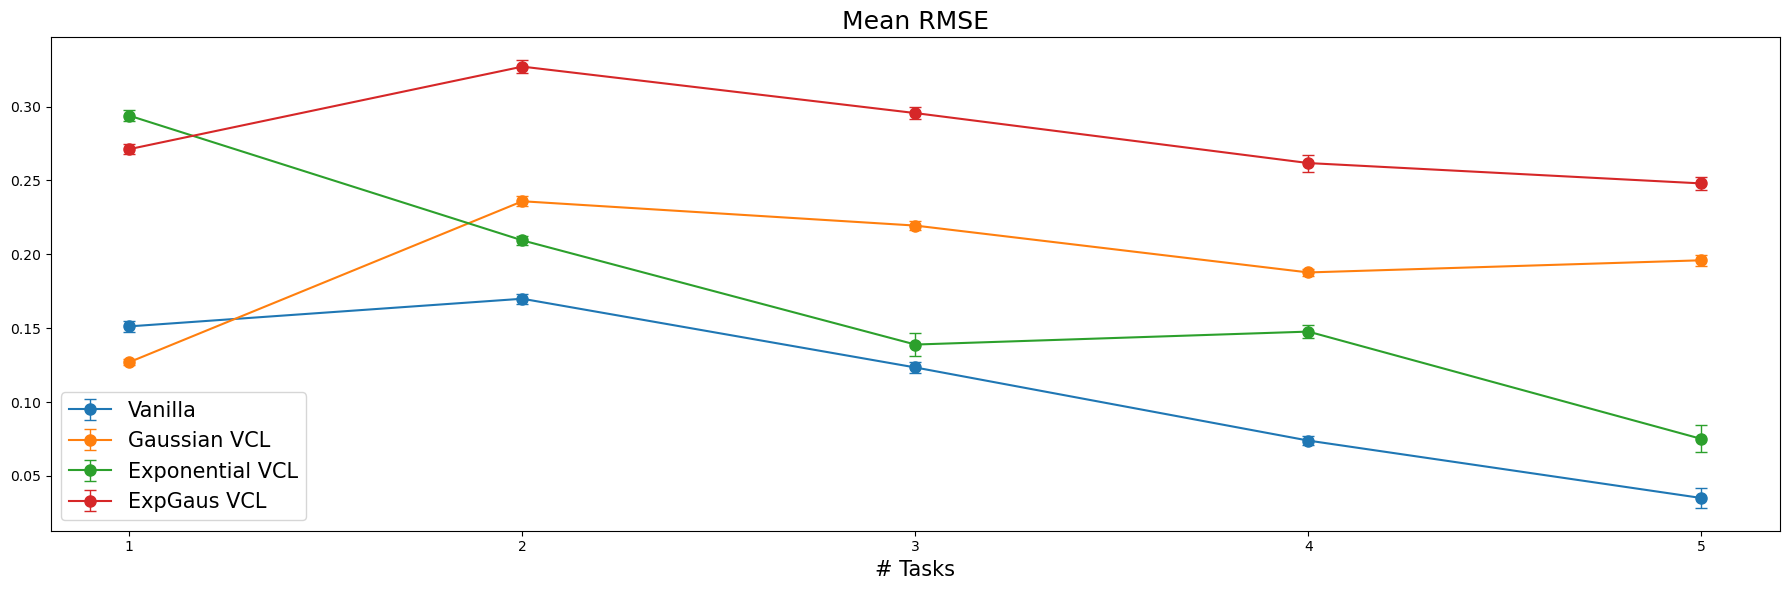

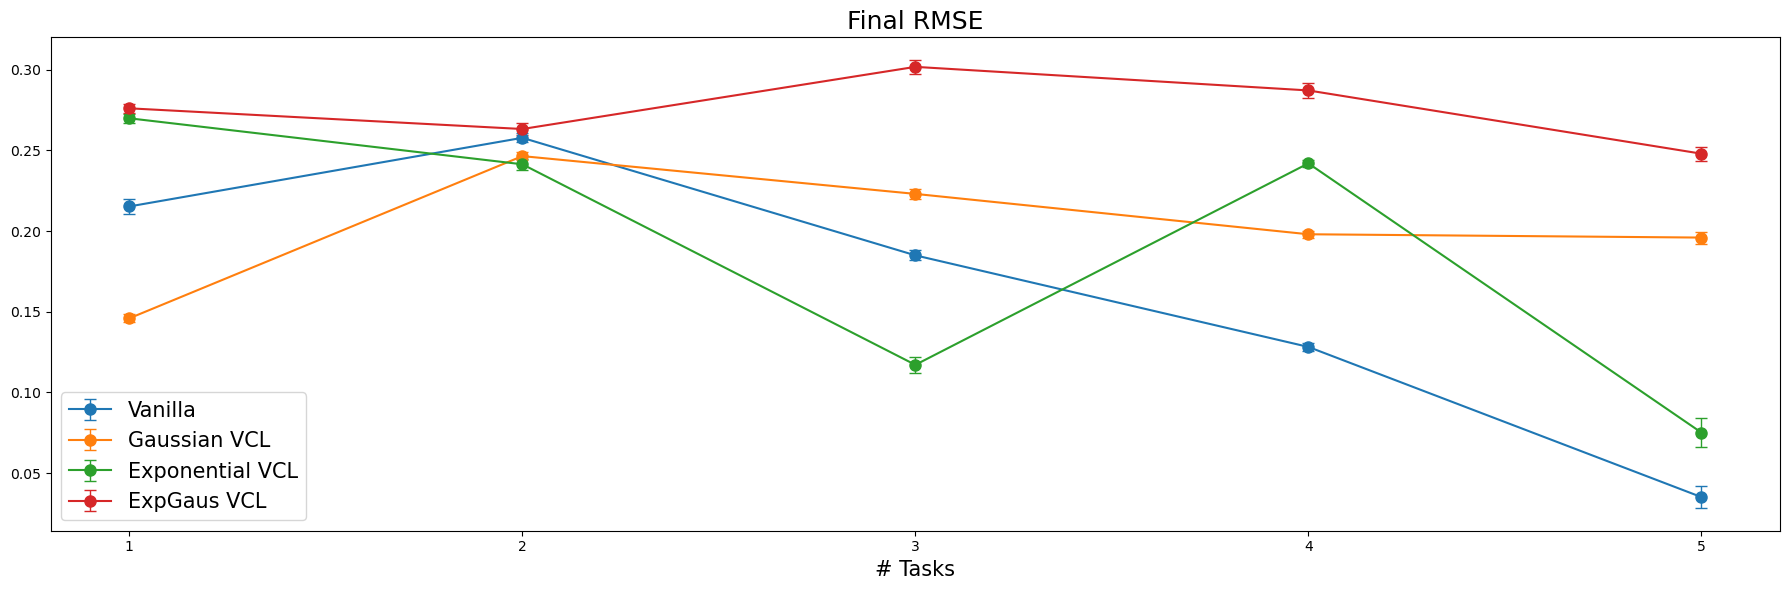

In [171]:
plot_mean_results(config, cmp_exploss_reg_results, cmp_exploss_reg_results_std)
plot_final_results(config, cmp_exploss_reg_results, cmp_exploss_reg_results_std)

# Changing Coreset Size

In [ ]:
config = ExperimentConfig()
config.dataset_type = 'split'
config.task_type = 'classification'
config.coreset_size = 100
config.validate()

torch.manual_seed(321)
np.random.seed(888)

# Run experiment
split_cla_results_100, split_cla_results_std_100 = run_experiment(config, ret_std=True)

In [ ]:
plot_results(config, split_cla_results_100, results_std=split_cla_results_std_100)

In [ ]:
config = ExperimentConfig()
config.dataset_type = 'split'
config.task_type = 'regression'
config.coreset_size = 100
config.validate()

torch.manual_seed(777)
np.random.seed(888)

# Run experiment
split_reg_results_100, split_reg_results_std_100 = run_experiment(config, ret_std=True)

In [ ]:
plot_results(config, split_reg_results_100, results_std=split_reg_results_std_100)

In [ ]:
plot_results(config, split_reg_results_0, results_std=split_reg_results_std_0)

# Changing Coreset Algorithm

In [ ]:
config = ExperimentConfig()
config.task_type = 'classification'
config.coreset_alg_name = 'kcenter'
config.validate()

# Run experiment
split_cla_results_kcenter, split_cla_results_kcenter_std = run_experiment(config, ret_std=True)

In [ ]:
plot_results(config, split_cla_results_kcenter, results_std=split_cla_results_kcenter_std)

In [ ]:
config = ExperimentConfig()
config.task_type = 'regression'
config.coreset_alg_name = 'kcenter'
config.validate()

# Run experiment
split_reg_results_kcenter, split_reg_results_kcenter_std = run_experiment(config, ret_std=True)

In [ ]:
plot_results(config, split_reg_results_kcenter, results_std=split_reg_results_kcenter_std)

In [ ]:
config = ExperimentConfig()
config.task_type = 'regression'
config.coreset_size = 0

# Run experiment
cla_results_none, cla_results_none_std = run_experiment(config, ret_std=True)

In [ ]:
plot_results(config, cla_results_none, results_std=cla_results_none_std)

In [ ]:
config = ExperimentConfig()
config.task_type = 'regression'
config.coreset_size = 0

# Run experiment
reg_results_none, reg_results_none_std = run_experiment(config, ret_std=True)

In [ ]:
plot_results(config, reg_results_none, results_std=reg_results_none_std)

# Compare multiple changes

In [229]:
from itertools import product

def get_all_configs(task_type, config_filter=None, 
                    init_prior_scale=0.1, coreset_sizes = [100, 200]):

    configs = []
    combos = list(product(['gaussian', 'exponential'], [None, 'random', 'kcenter'], 
                          coreset_sizes, [True, False]))
    # no coreset
    combos = [(p,ca,0,u) if ca is None else (p,ca,cs,u) for p,ca,cs,u in combos]
    # gaussian not affected by the update_prior_type attribute
    combos = [(p,ca,cs,False) if p == 'gaussian' else (p,ca,cs,u) for p,ca,cs,u in combos]
    combos = list(set(combos))
    for combo in combos:
        prior_type, coreset_alg_name, coreset_size, update_prior_type = combo
        configs.append(ExperimentConfig(task_type=task_type,
                                          prior_type=prior_type,
                                          init_prior_scale=init_prior_scale,
                                          coreset_alg_name=coreset_alg_name,
                                          coreset_size=coreset_size,
                                          update_prior_type=update_prior_type))
    return list(filter(config_filter, configs))

In [230]:
configs = get_all_configs('classification', 
                config_filter= (lambda c : c.prior_type == 'exponential'))
[c.name for c in configs]

['ExpGaussianVCL (Random, 200)',
 'ExpGaussianVCL (None, 0)',
 'ExpGaussianVCL (Kcenter, 200)',
 'ExpVCL (None, 0)',
 'ExpVCL (Kcenter, 200)',
 'ExpVCL (Random, 200)',
 'ExpGaussianVCL (Kcenter, 100)',
 'ExpGaussianVCL (Random, 100)',
 'ExpVCL (Random, 100)',
 'ExpVCL (Kcenter, 100)']

In [231]:
def run_experiment_multi(task_type, configs=None, config_filter=None,
                         init_prior_scale=0.1, coreset_sizes=[100,200], 
                         print_progress=False, ret_std=True):
    """Run complete VCL experiment"""
    if configs is None:
        configs = get_all_configs(task_type, config_filter,
                                  init_prior_scale, coreset_sizes)
    # Initialize models
    models = {c.name: VCLNN(c).to(DEVICE) for c in configs}
    vanillaNN = VanillaNN(ExperimentConfig()).to(DEVICE) 
    models['Vanilla'] = vanillaNN

    results = {}
    results_std = {}
    for model_name, model in models.items():
        res, res_std = run_experiment_for(model, print_progress=print_progress)
        results[model_name] = res
        results_std[model_name] = res_std
    return results if not ret_std else (results, results_std)

In [232]:
torch.manual_seed(777)
np.random.seed(888)
cla_results, cla_std = run_experiment_multi('classification')

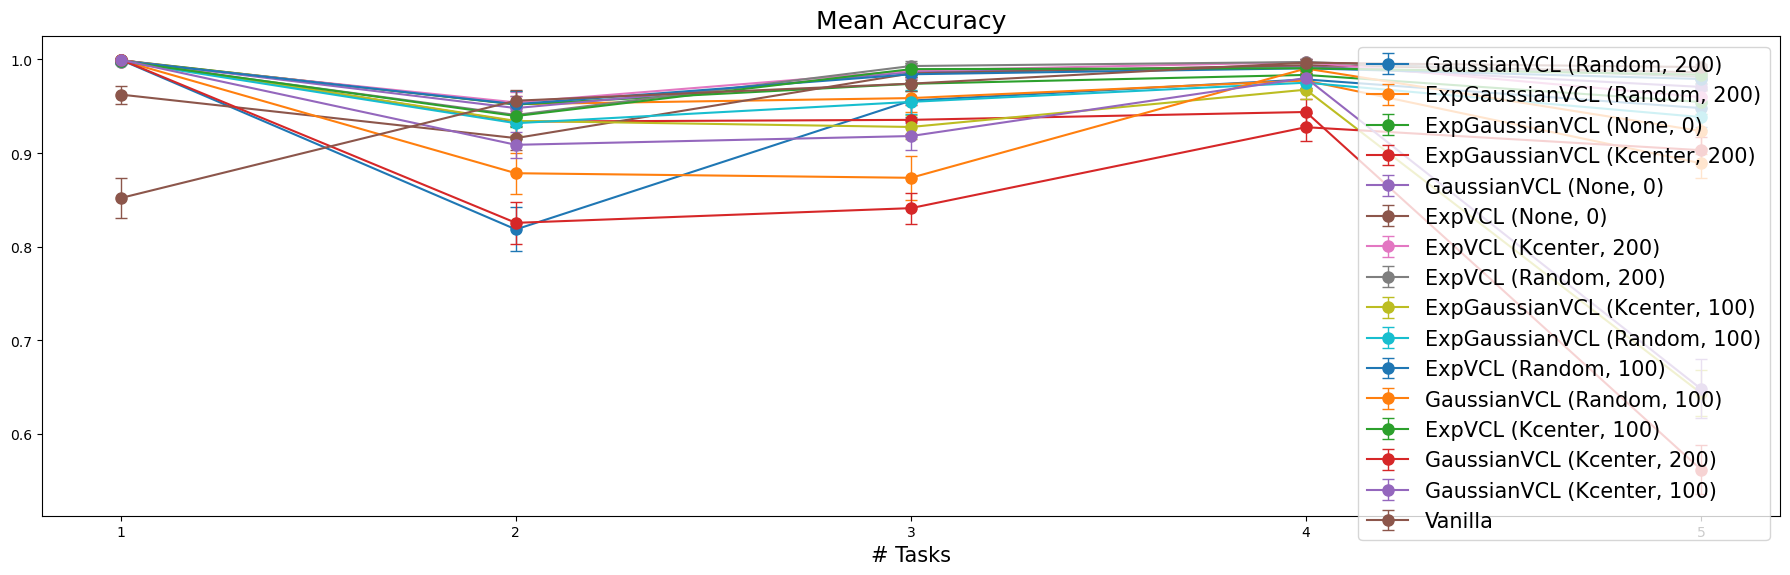

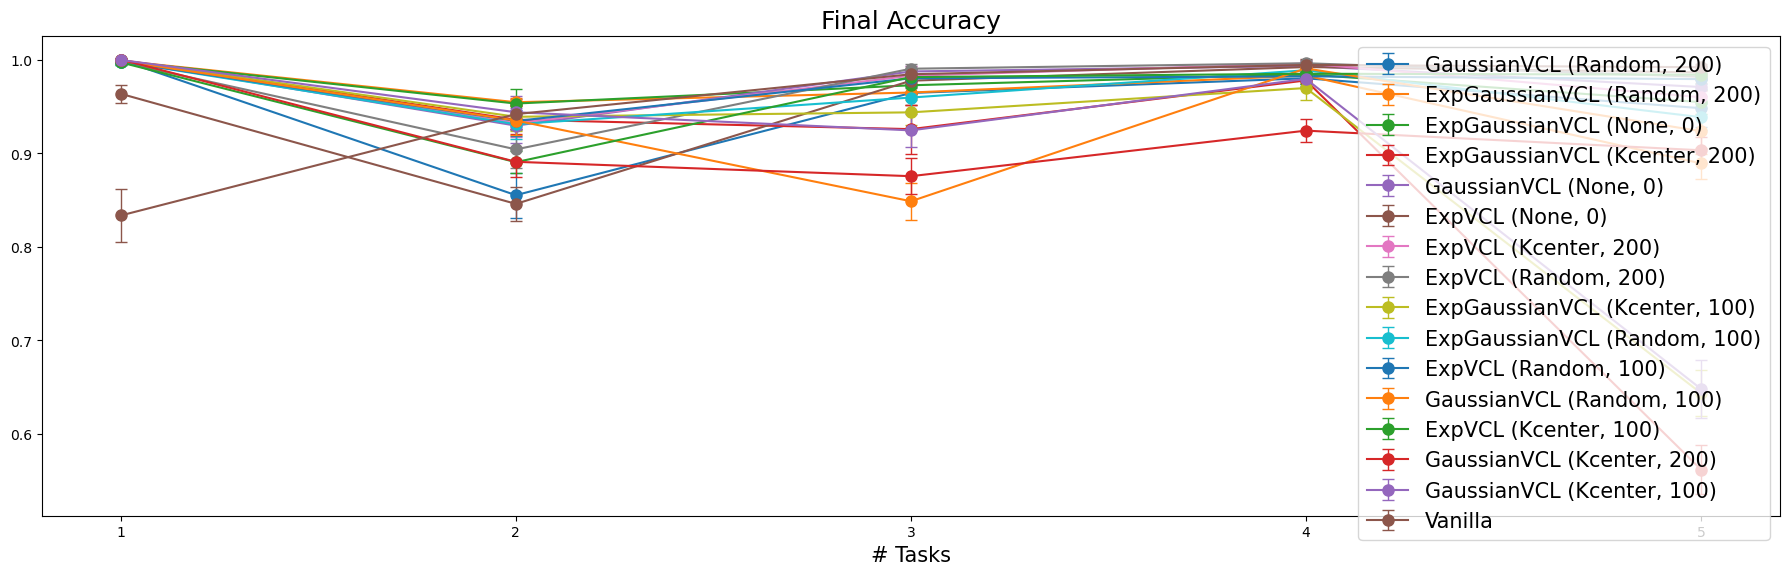

In [233]:
plot_mean_results(ExperimentConfig(task_type='classification'), cla_results, results_std=cla_std)
plot_final_results(ExperimentConfig(task_type='classification'), cla_results, results_std=cla_std)

In [98]:
def run_experiment_multi(task_type='classification', init_prior_scale=0.1, coreset_size=200, ret_std=True):
    """Run complete VCL experiment"""
    gaussian_none_config = ExperimentConfig(task_type=task_type,
                                            init_prior_scale=init_prior_scale,
                                            coreset_size=0)
    exp_none_config = ExperimentConfig(task_type=task_type, 
                                               prior_type = 'exponential',
                                               init_prior_scale=init_prior_scale,
                                               coreset_size=0)
    
    gaussian_random_config = ExperimentConfig(task_type=task_type,
                                              init_prior_scale=init_prior_scale,
                                              coreset_size=coreset_size)
    exp_random_config = ExperimentConfig(task_type=task_type, 
                                          prior_type = 'exponential',
                                          init_prior_scale=init_prior_scale,
                                          coreset_size=coreset_size)
    
    gaussian_kcenter_config = ExperimentConfig(task_type=task_type,
                                               coreset_alg_name='kcenter',
                                               init_prior_scale=init_prior_scale,
                                               coreset_size=coreset_size)
    exp_kcenter_config = ExperimentConfig(task_type=task_type, 
                                                  prior_type = 'exponential',
                                                  coreset_alg_name='kcenter',
                                                  init_prior_scale=init_prior_scale,
                                                  coreset_size=coreset_size)
    
    
    # Initialize models
    vanillaNN = VanillaNN(gaussian_none_config).to(DEVICE)  # VanillaNN does not use coreset anyways
    gaussian_none_vclNN = VCLNN(gaussian_none_config).to(DEVICE)
    exp_none_vclNN = VCLNN(exp_none_config).to(DEVICE)
    gaussian_random_vclNN = VCLNN(gaussian_random_config).to(DEVICE)
    exp_random_vclNN = VCLNN(exp_random_config).to(DEVICE)
    gaussian_kcenter_vclNN = VCLNN(gaussian_kcenter_config).to(DEVICE)
    exp_kcenter_vclNN = VCLNN(exp_kcenter_config).to(DEVICE)
    

    vanilla_results, vanilla_results_std = run_experiment_for(vanillaNN)
    gaussian_none_vcl_results, gaussian_none_vcl_results_std = run_experiment_for(gaussian_none_vclNN)
    exp_none_vcl_results, exp_none_vcl_results_std = run_experiment_for(exp_none_vclNN)
    gaussian_random_vcl_results, gaussian_random_vcl_results_std = run_experiment_for(gaussian_random_vclNN)
    exp_random_vcl_results, exp_random_vcl_results_std = run_experiment_for(exp_random_vclNN)
    gaussian_kcenter_vcl_results, gaussian_kcenter_vcl_results_std = run_experiment_for(gaussian_kcenter_vclNN)
    exp_kcenter_vcl_results, exp_kcenter_vcl_results_std = run_experiment_for(exp_kcenter_vclNN)
    
    results = { 'Vanilla': vanilla_results, 
               'GaussianVCL (None)': gaussian_none_vcl_results, 'ExpVCL (None)': exp_none_vcl_results,
               'GaussianVCL (Random)': gaussian_random_vcl_results, 'ExpVCL (Random)': exp_random_vcl_results,
               'GaussianVCL (K-center)': gaussian_kcenter_vcl_results, 'ExpVCL (K-center)': exp_kcenter_vcl_results }
    results_std = { 'Vanilla': vanilla_results_std, 
                    'GaussianVCL (None)': gaussian_none_vcl_results_std, 'ExpVCL (None)': exp_none_vcl_results_std,
                    'GaussianVCL (Random)': gaussian_random_vcl_results_std, 'ExpVCL (Random)': exp_random_vcl_results_std,
                    'GaussianVCL (K-center)': gaussian_kcenter_vcl_results_std, 'ExpVCL (K-center)': exp_kcenter_vcl_results_std }
    
    return results if not ret_std else (results, results_std)

In [215]:
cla_results

{'Vanilla': array([[0.99913194, 0.        , 0.        , 0.        , 0.        ],
        [0.99826389, 0.99121094, 0.        , 0.        , 0.        ],
        [0.89428508, 0.96770313, 0.99853516, 0.        , 0.        ],
        [0.73975824, 0.947125  , 0.97589558, 0.99951172, 0.        ],
        [0.91180167, 0.94368359, 0.97992092, 0.98634826, 0.99022415]]),
 'Gaussian VCL (None)': array([[0.99956597, 0.        , 0.        , 0.        , 0.        ],
        [0.99956597, 0.97164453, 0.        , 0.        , 0.        ],
        [0.99956597, 0.96523828, 0.99121094, 0.        , 0.        ],
        [0.99956597, 0.95933203, 0.98870999, 0.99154317, 0.        ],
        [0.99956597, 0.93730078, 0.99072266, 0.99007833, 0.96253783]]),
 'Exponential VCL (None)': array([[1.        , 0.        , 0.        , 0.        , 0.        ],
        [0.90643786, 0.99412891, 0.        , 0.        , 0.        ],
        [0.63577943, 0.90648047, 0.99853516, 0.        , 0.        ],
        [0.46697502, 0.880

In [217]:
cla_std

{'Vanilla': array([[0.00162398, 0.        , 0.        , 0.        , 0.        ],
        [0.00194103, 0.00609863, 0.        , 0.        , 0.        ],
        [0.0257697 , 0.00882914, 0.00189111, 0.        , 0.        ],
        [0.02446531, 0.01304423, 0.01043559, 0.00129187, 0.        ],
        [0.028667  , 0.01185804, 0.00832885, 0.00676022, 0.00553517]]),
 'Gaussian VCL (None)': array([[0.00122762, 0.        , 0.        , 0.        , 0.        ],
        [0.00122762, 0.00815795, 0.        , 0.        , 0.        ],
        [0.00122762, 0.00962509, 0.00577742, 0.        , 0.        ],
        [0.00122762, 0.01162754, 0.00689407, 0.00521256, 0.        ],
        [0.00122762, 0.02005935, 0.00975341, 0.00571612, 0.00795515]]),
 'Exponential VCL (None)': array([[0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.01914137, 0.00390051, 0.        , 0.        , 0.        ],
        [0.02527485, 0.01442796, 0.00189111, 0.        , 0.        ],
        [0.02738584, 0.015

In [142]:
torch.manual_seed(777)
np.random.seed(888)
cla_results, cla_std = run_experiment_multi(task_type='classification')

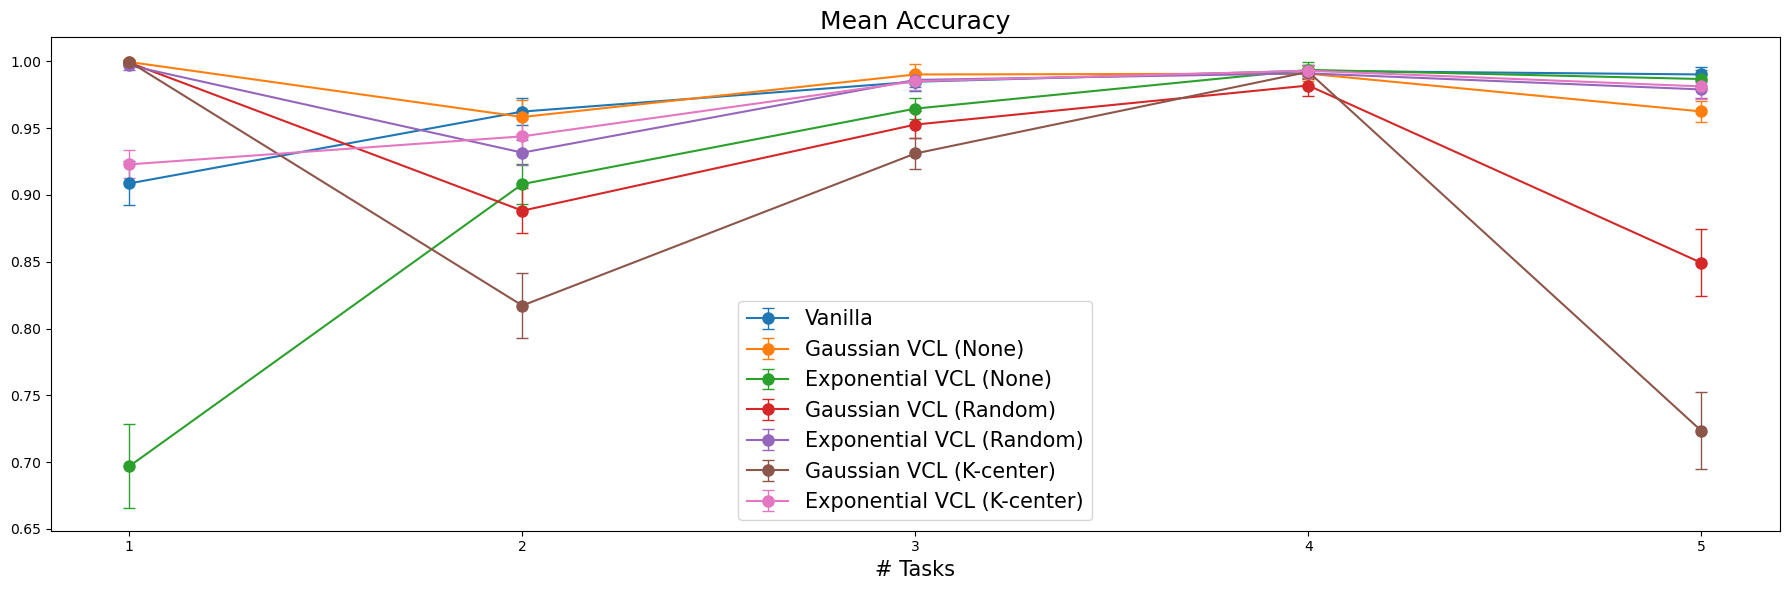

In [143]:
%run utils.ipynb
plot_mean_results(ExperimentConfig(task_type='classification'), cla_results, results_std=cla_std)

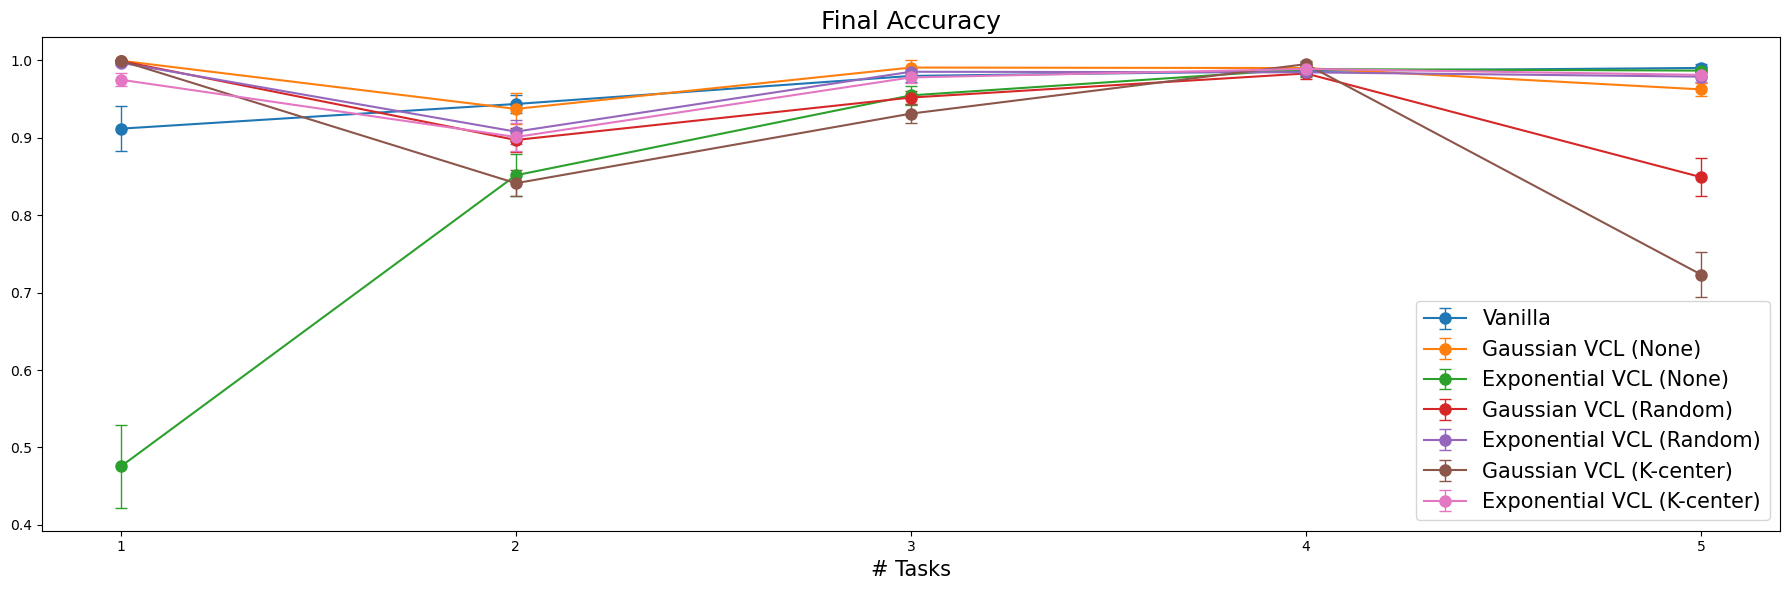

In [144]:
plot_final_results(ExperimentConfig(task_type='classification'), cla_results, results_std=cla_std)

In [145]:
torch.manual_seed(777)
np.random.seed(888)
reg_results, reg_std = run_experiment_multi(task_type='regression')

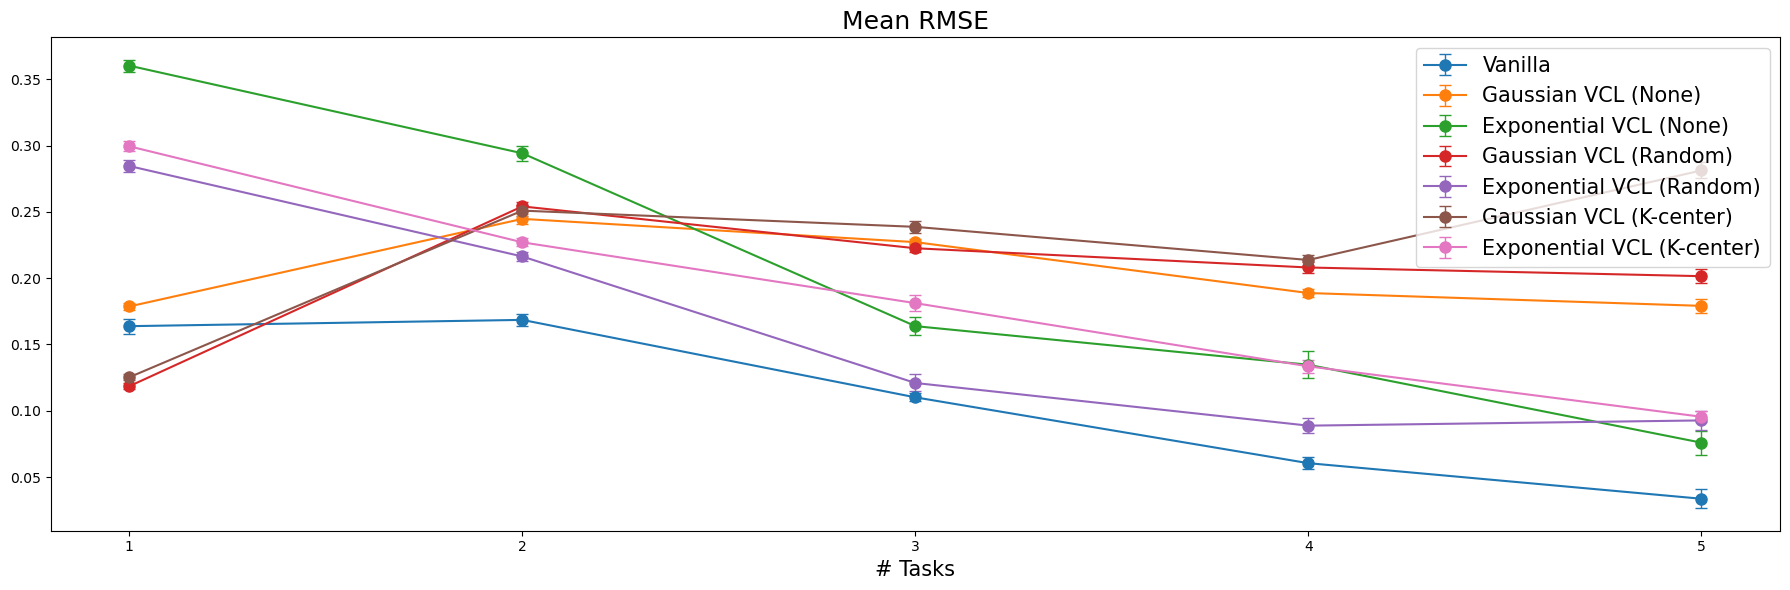

In [147]:
plot_mean_results(ExperimentConfig(task_type='regression'), reg_results, results_std=reg_std)

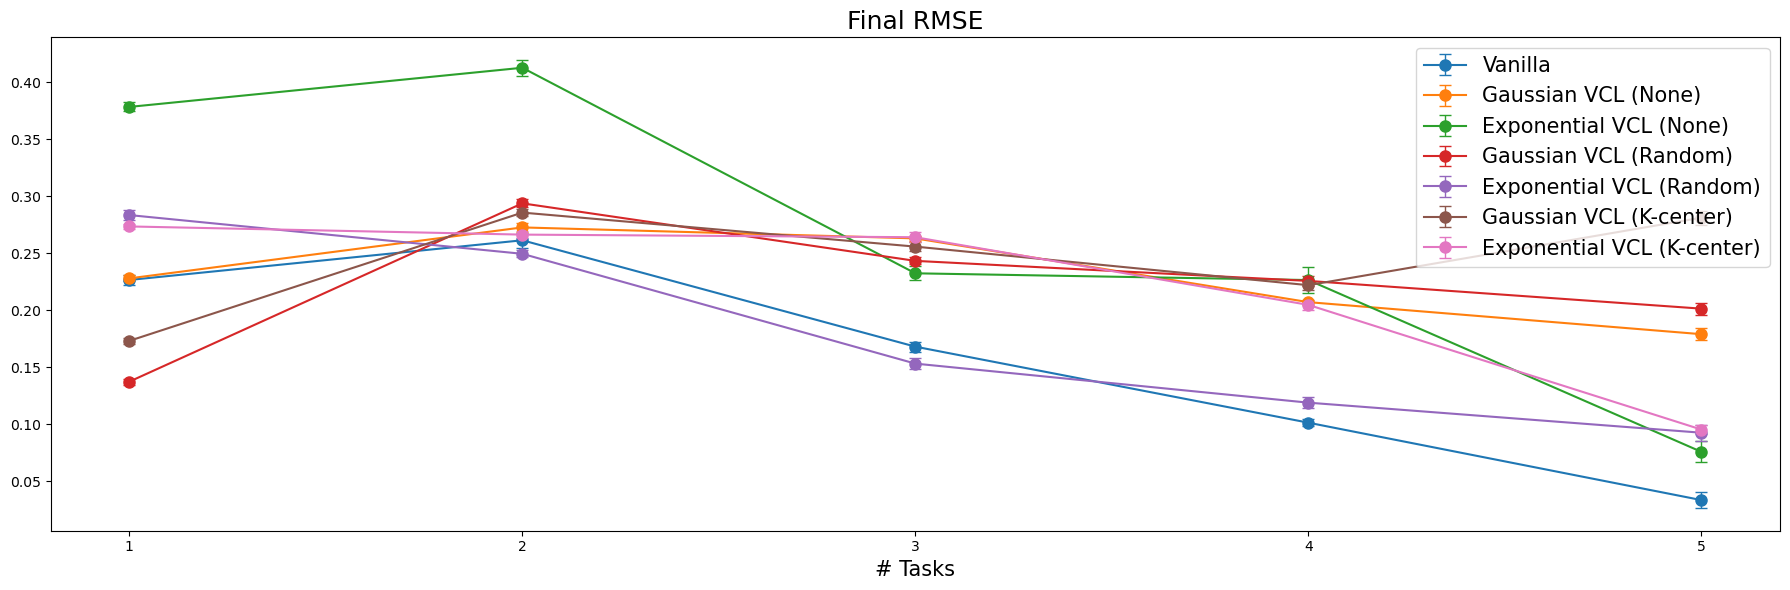

In [148]:
plot_final_results(ExperimentConfig(task_type='regression'), reg_results, results_std=reg_std)

## Using a smaller scale

In [103]:
torch.manual_seed(777)
np.random.seed(888)
small_scale_cla_results, small_scale_cla_std = run_experiment_multi(task_type='classification',
                                                                    init_prior_scale=0.01)

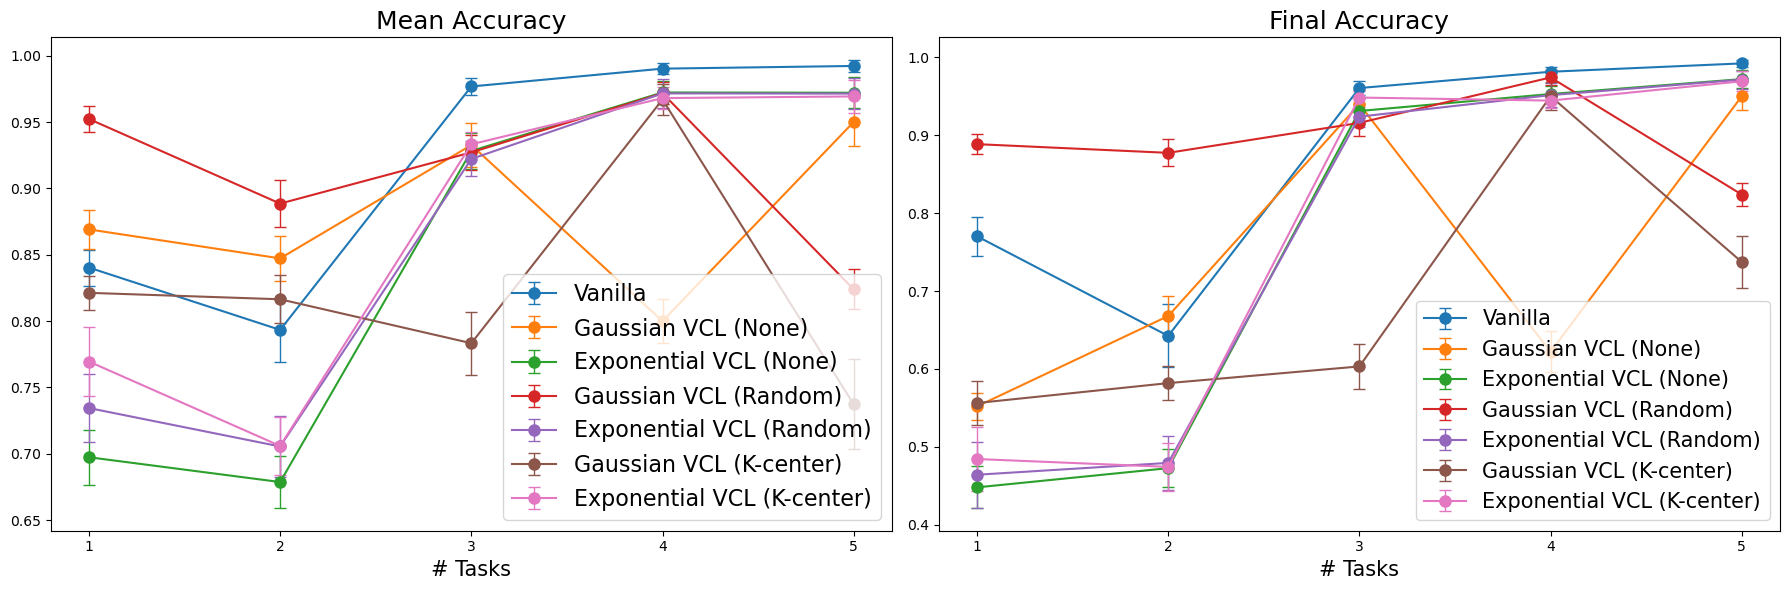

In [104]:
plot_results(ExperimentConfig(task_type='classification', init_prior_scale=0.01), 
             small_scale_cla_results, results_std=small_scale_cla_std)

In [105]:
torch.manual_seed(777)
np.random.seed(888)
small_scale_reg_results, small_scale_reg_std = run_experiment_multi(task_type='regression',
                                                                    init_prior_scale=0.01)

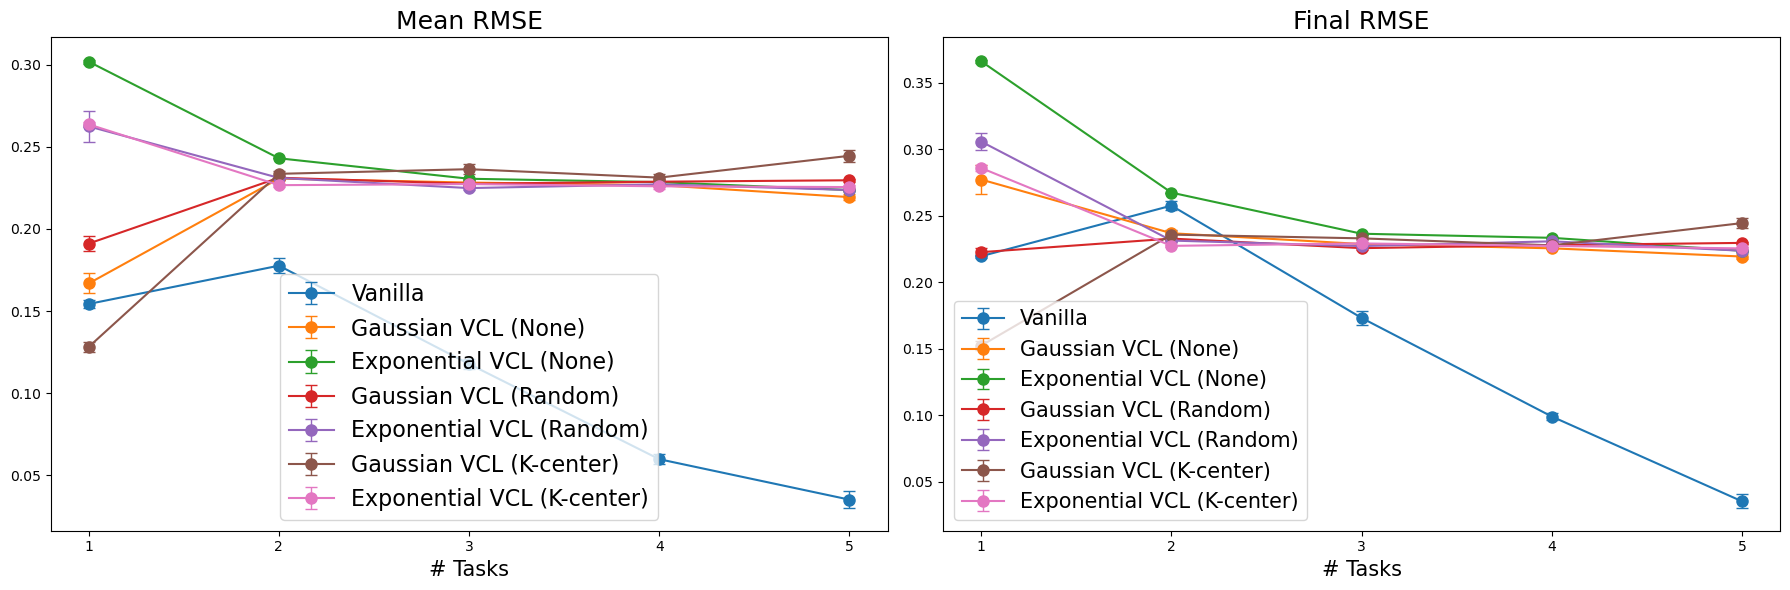

In [106]:
plot_results(ExperimentConfig(task_type='regression', init_prior_scale=0.01), 
             small_scale_reg_results, results_std=small_scale_reg_std)

## Using a smaller coreset

In [150]:
torch.manual_seed(777)
np.random.seed(888)
small_coreset_cla_results, small_coreset_cla_std = run_experiment_multi(task_type='classification',
                                                                  coreset_size=100)

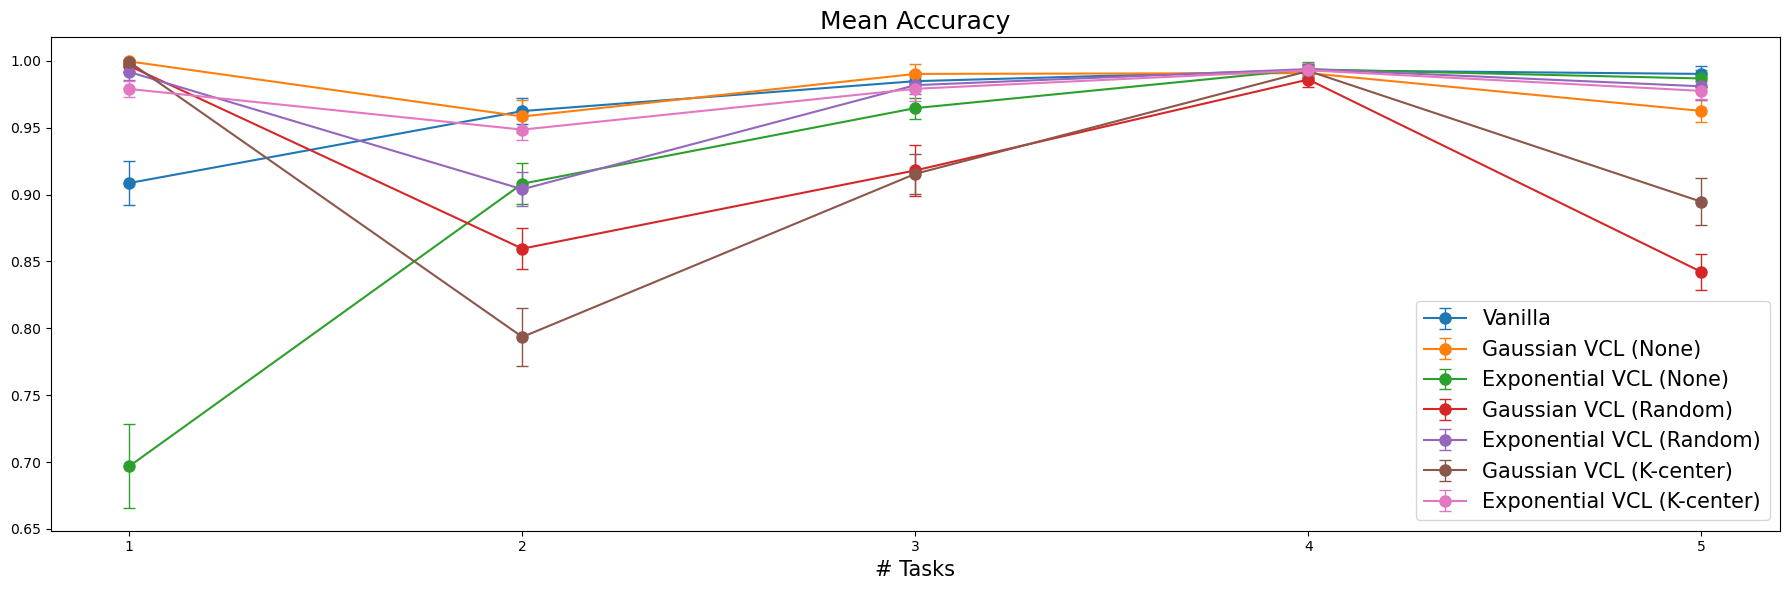

In [151]:
plot_mean_results(ExperimentConfig(task_type='classification', coreset_size=100), 
                  small_coreset_cla_results, results_std=small_coreset_cla_std)

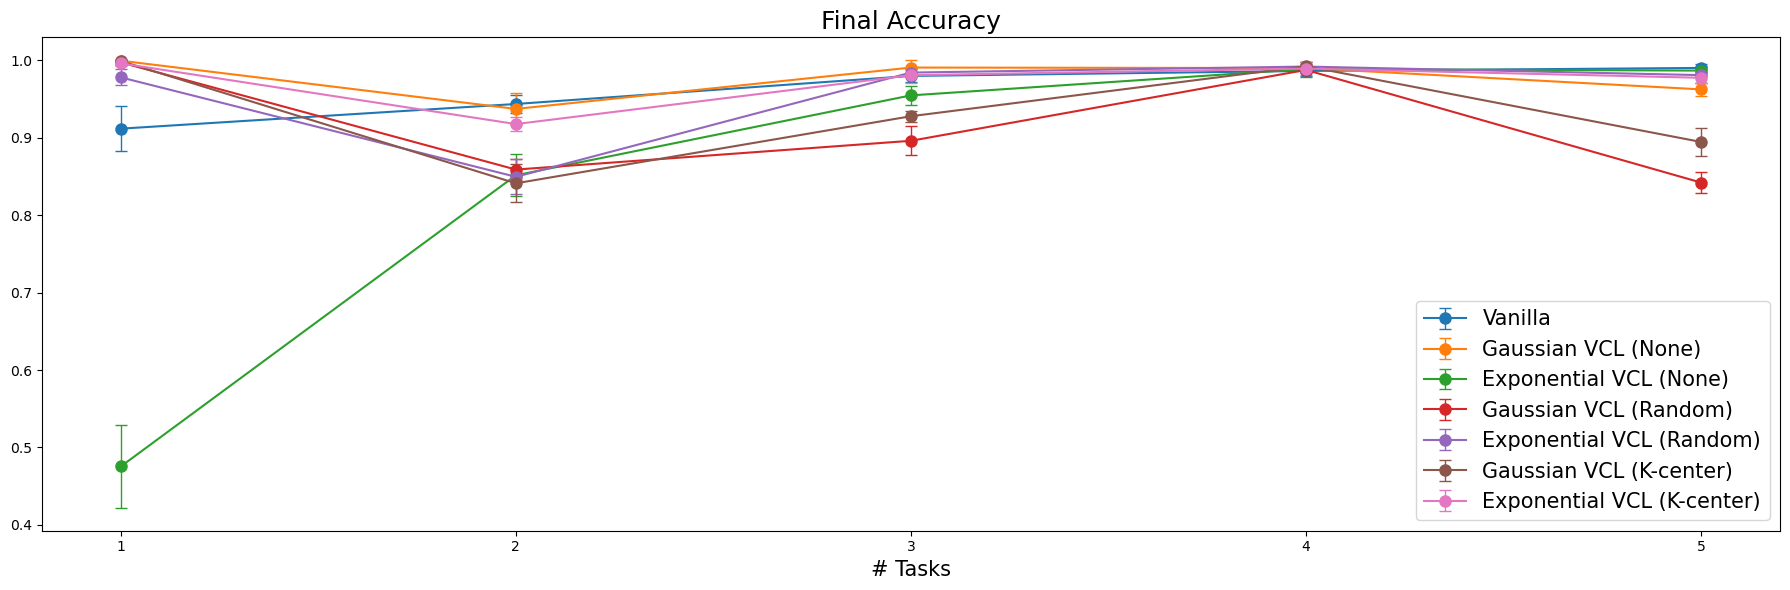

In [152]:
plot_final_results(ExperimentConfig(task_type='classification', coreset_size=100), 
                  small_coreset_cla_results, results_std=small_coreset_cla_std)

In [153]:
torch.manual_seed(777)
np.random.seed(888)
small_coreset_reg_results, small_coreset_reg_std = run_experiment_multi(task_type='regression',
                                                                        coreset_size=100)

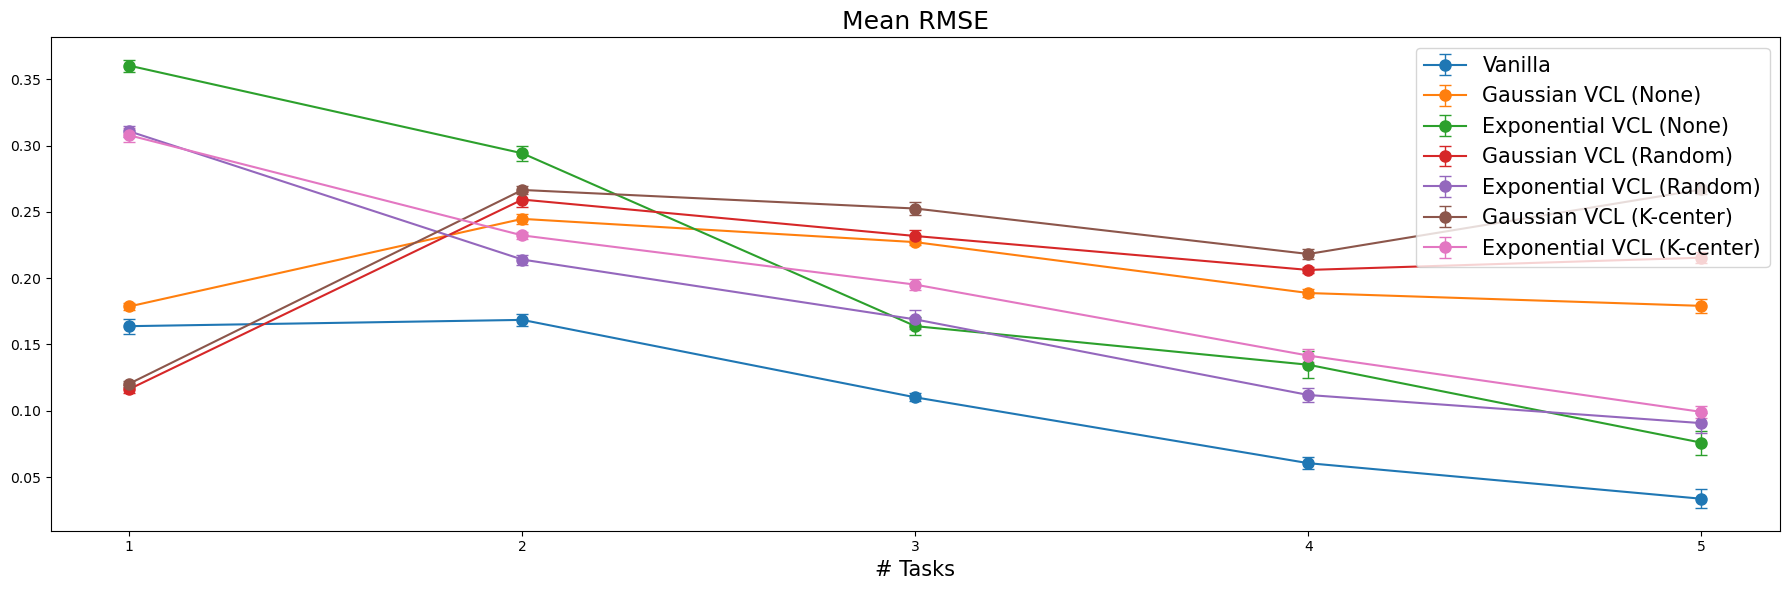

In [154]:
plot_mean_results(ExperimentConfig(task_type='regression', coreset_size=100), 
                  small_coreset_reg_results, results_std=small_coreset_reg_std)

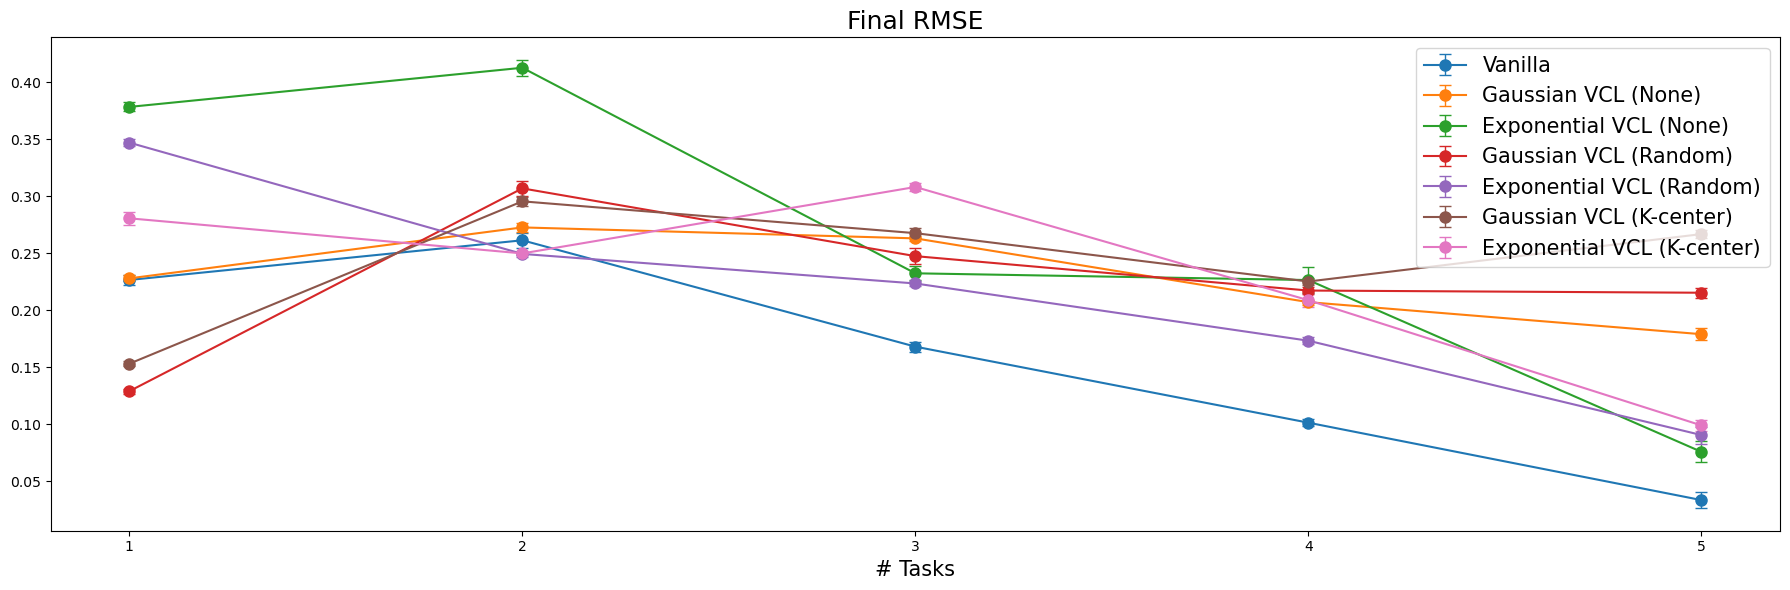

In [155]:
plot_final_results(ExperimentConfig(task_type='regression', coreset_size=100), 
                   small_coreset_reg_results, results_std=small_coreset_reg_std)